# SVD of Minute-Market-Data
### Dan Schmidt's Script Fall 2016

In [2]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2
import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)
%aimport preprocess
from preprocess.process import get_symbol
from preprocess.process import get_symbols_matrix
from preprocess.process import df_to_returns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from IPython.core.debugger import Tracer
import scipy as sp
from scipy.linalg import svd
from sklearn.decomposition import PCA
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing
Read the data in, convert dates to a useful format

In [3]:
data_loc = "/home/dan/code/market_data/"
symbols = [line.rstrip('\n') for line in open(data_loc+'sp500.txt')]

# Running the SVD on two weeks in 2015, check error on next week
train_start_date = "03/02/2015"
train_end_date = "03/14/2015"

test_start_date = "03/15/2015"
test_end_date = "03/21/2015"

#aapl = get_symbol("AAPL", data_loc, train_start_date, train_end_date)

test_symbols = symbols[400:]
print(test_symbols)

test_mat, syms = get_symbols_matrix(
    test_symbols, data_loc, train_start_date, train_end_date
)

['SEE', 'SE', 'SHW', 'SIG', 'SJM', 'SLB', 'SLG', 'SNA', 'SNI', 'SO', 'SPGI', 'SPG', 'SPLS', 'SRCL', 'SRE', 'STI', 'STJ', 'STT', 'STX', 'STZ', 'SWKS', 'SWK', 'SWN', 'SYF', 'SYK', 'SYMC', 'SYY', 'TAP', 'TDC', 'TDG', 'TEL', 'TGNA', 'TGT', 'TIF', 'TJX', 'TMK', 'TMO', 'TRIP', 'TROW', 'TRV', 'TSCO', 'TSN', 'TSO', 'TSS', 'TWX', 'TXN', 'TXT', 'T', 'UAL', 'UA', 'UDR', 'UHS', 'ULTA', 'UNH', 'UNM', 'UNP', 'UPS', 'URBN', 'URI', 'USB', 'UTX', 'VAR', 'VFC', 'VIAB', 'VLO', 'VMC', 'VNO', 'VRSK', 'VRSN', 'VRTX', 'VTR', 'V', 'VZ', 'WAT', 'WBA', 'WDC', 'WEC', 'WFC', 'WFM', 'WHR', 'WLTW', 'WMB', 'WMT', 'WM', 'WRK', 'WU', 'WYNN', 'WYN', 'WY', 'XEC', 'XEL', 'XLNX', 'XL', 'XOM', 'XRAY', 'XRX', 'XYL', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS']
Reading SEE from pickle
SEE failed integrity check
Reading SE from pickle
Reading SHW from pickle
SHW failed integrity check
Reading SIG from pickle
SIG failed integrity check
Reading SJM from pickle
SJM failed integrity check
Reading SLB from pickle
Reading SLG from pickle
S

In [4]:
X = test_mat.values.T

# Remove the mean (which roughly removes linear 2-week trend)
Xmean = X.mean(axis=0)
Xd = X-Xmean
#Xd = X

print(Xd.shape)
# Try the SVD
U, S, VT = svd(X)

(48, 3893)


In [5]:
print(U.shape)
print(S.shape)
print(VT.shape)
print(Xmean.shape)


(48, 48)
(48,)
(3893, 3893)
(3893,)


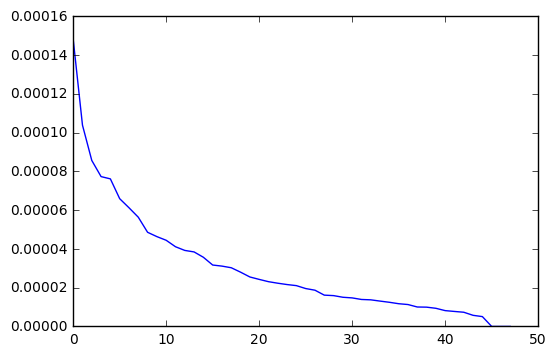

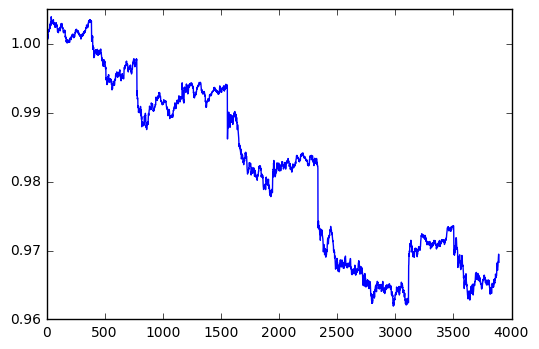

Reading SPY from pickle


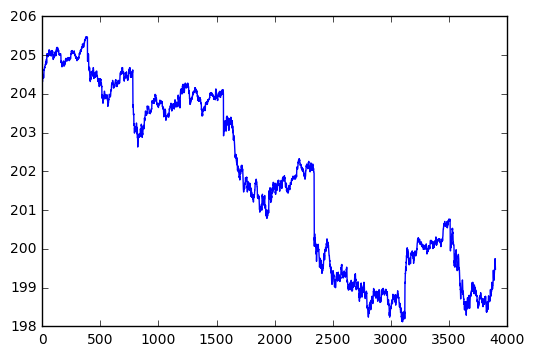

In [6]:
pca = PCA(svd_solver='randomized')
pca.fit(Xd)

plt.plot(pca.explained_variance_)
plt.show()

market = pca.components_[0, :]
plt.plot( (1+(Xmean)).cumprod() )
plt.show()

# compare to actual market
spy = get_symbol("SPY", data_loc, train_start_date, train_end_date)

plt.plot(spy['Close'].values)
plt.show()

In [ ]:
# Bayesian MLP

# Hyperparameters
middle_dim = window_length
encoding_dim = 10
reg = 1e-12
ret_thresh = 1e-2

input_w = Input(shape=(2*window_length,))

in_layer = Dense(
    middle_dim,
    init='normal',
    activation='tanh',
    W_regularizer=l2(reg))(input_w)

mid_layer = Dense(
    encoding_dim,
    init='normal', 
    activation='tanh',
    W_regularizer=l2(reg))(in_layer)

output = Dense(
    1,
    init='normal',
    activation='sigmoid')(mid_layer)

mlp_pred = Model(input=input_w, output=output)
mlp_pred.compile(optimizer='adam', loss='binary_crossentropy')

dm_y = (np.abs(aapl_y[:, 0]) > ret_thresh)*(1 / (2*aapl_y[:,0]))+0.5
dm_val = (np.abs(val_y[:,0]) > ret_thresh)*(1 / (2*val_y[:,0]))+0.5

aapl_f = np.concatenate( (aapl_rets, aapl_vol), axis=1)
val_f = np.concatenate( (val_rets, val_vol), axis=1)

mlp_pred.fit(
    aapl_f, 
    dm_y, 
    batch_size=100,
    nb_epoch=25,
    shuffle=True, 
    validation_data=(val_f, dm_val) 
)